# Forecasting - ARIMA

## Intro

ARIMA - AutoRegressive Integrated Moving Average


- ARIMA does not work for all time of time series, e.g., for stock price data there are so many outside factors that much of the data that informs the price is outside features that is not inherent only in the time series data by itself

- ARIMA works well if the data is directly related to the time stamp (e.g., the airline passengers dataset)

- ARIMA is a generalization of an ARMA model (AutoRegressive moving average)

- There is also SARIMA, where the S stands for Seasonal

- There is also SARIMAX, where the X stands for exogenous variables



- ARIMA has parameters p, d, and q 

    - AR component (AutoRegression): parameter p; regression model, that utilizes dependent relationship between current observation and observations over a previous period
    - I component (integrated): parameter q; differencing of observations in order to make the time series stationary
    - MA component (moving average): parameter d: model that uses dependency between observation and residual error from a moving average model applied to lagged observations
    
    
    
Reminder: Stationary mean that the time series has constant mean and variance over time.

Stationary allows to predict mean and variance that will be the same in the future.

Commonly the Augmented Dickey-Fuller test can be used to determine if the dataset is stationary or not. If the dataset is not stationary, one needs to do differencing for example to make the time series stationary. 


Methods of choosing p, d and q:

- Method 1): Use ACF and PACF plots, but they can be difficult to read
- Method 2): Grid Search --> takes time. Run ARIMA on different combinations and p, d and q
    - Due to computational power increasing, it is becoming more and more popular
    - Usually this is more accurate than reading values

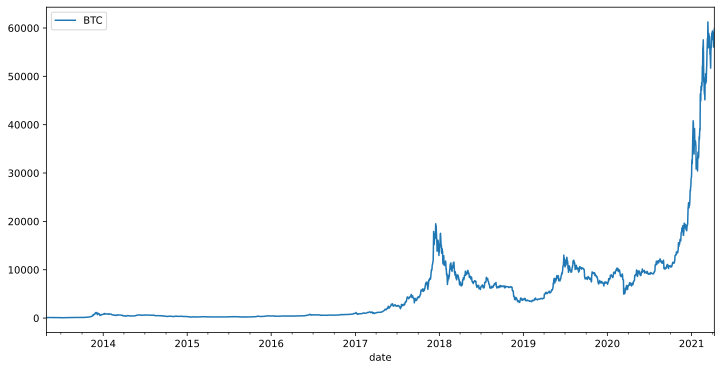

In [1]:
import os
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from IPython.display import set_matplotlib_formats
import seaborn as sns
from statsmodels.tsa.filters.hp_filter import hpfilter
set_matplotlib_formats('svg')

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error

folder = f'../02.Prepared_data/2021-04-11/'

def load_coins(folder):
#     folder = f'../02.Prepared_data/2021-04-05/'
    
    BTC = pd.read_csv(f"{folder}/BTC_Bitcoin.csv", index_col=0, parse_dates=['date'])
    ETH = pd.read_csv(f"{folder}/ETH_Ethereum.csv", index_col=0, parse_dates=['date'])
    XMR = pd.read_csv(f"{folder}/XMR_Monero.csv", index_col=0, parse_dates=['date'])
    DASH = pd.read_csv(f"{folder}/DASH_Dash.csv", index_col=0, parse_dates=['date'])
    LTC = pd.read_csv(f"{folder}/LTC_Litecoin.csv", index_col=0, parse_dates=['date'])
    XRP = pd.read_csv(f"{folder}/XRP_XRP.csv", index_col=0, parse_dates=['date'])
    ADA = pd.read_csv(f"{folder}/ADA_Cardano.csv", index_col=0, parse_dates=['date'])
    DOT = pd.read_csv(f"{folder}/DOT_Polkadot.csv", index_col=0, parse_dates=['date'])

    coins = [ETH, XMR, DASH, LTC, XRP, ADA, DOT]
    # make sure that all have date as index
    new_coins = []
    for df in coins:
        df = df.sort_values(by='date')
        df = df.drop_duplicates(subset='date', keep='first')
        df = df.set_index('date', drop=True)
        df = df.asfreq('D', method='ffill')
        new_coins.append(df)

    BTC = BTC.sort_values(by='date')
    BTC = BTC.drop_duplicates(subset='date', keep='first')
    BTC = BTC.set_index('date', drop=True)
    BTC = BTC.asfreq('D', method='ffill')
    coins = [BTC] + new_coins

    cols = ['BTC', 'ETH', 'XMR', 'DASH', 'LTC', 'XRP', 'ADA', 'DOT']
    df = pd.DataFrame()

    for col, coin in zip(cols, coins):
        vals = coin['close'].asfreq('D', method='ffill') # in case there were some skipped days
        df[col] = vals
        
    return df


coins = load_coins(folder)
BTC = pd.DataFrame()
BTC['BTC'] = coins['BTC']

BTC.loc[:].plot(figsize=(12,6))
BTC.head()

path = '../01.Original_data/time_series_course_Data/'
data_passengers = pd.read_csv(f"{path}airline_passengers.csv", parse_dates=True, index_col=0)
data_births = pd.read_csv(f"{path}daily_female_births.csv", parse_dates=True, index_col=0)